<h1>Cool Maths</h1>

<h2>Local Expensive Min</h2>
<h3>Libraries</h3>

In [2]:
%reload_ext blackcellmagic

In [275]:
import asyncio
import bisect
from collections.abc import Iterable
import math
from pprint import pprint

from IPython import display
from IPython.display import HTML


import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from matplotlib.animation import HTMLWriter

import numpy as np
from numpy.polynomial import Polynomial

import scipy
from scipy import optimize as opt
from scipy.interpolate import splrep, splev, interp1d, CubicSpline

<h3>Functions</h3>

In [276]:
def f(x):
    return np.sin(x) + 0.05 * x ** 2
    

def slow(x):
    #await asyncio.sleep(0.01)
    y = f(x)
    return y + np.random.normal(0, 0.2, size=np.size(y))


def fit(X, Y, alpha = None):
    if X.size == 2:
        return Polynomial.fit(X, Y, deg=1)
    if X.size == 3:
        return Polynomial.fit(X, Y, deg=2)
    if alpha is None:
        alpha = len(X)**2/200
    spl = splrep(X, Y, s = alpha)
    return lambda x: splev(x, spl)


def uncertainty(fit, limits, X, x):
    def height(fit, limits, x=None):
        if x is None:
            x = np.linspace(*limits, 50)
        y = -fit(x)
        y -= y.min()
        y /= y.max()
        return y + 0.01

    def sparcity(fit, limits, X, x=None):
        if x is None:
            x = np.linspace(*limits, 50)
        prob = np.zeros_like(x)
        for j, point in enumerate(x):
            prob[j] = np.min(np.abs(X-point))
        return prob

    probY = height(approx, limits, x)
    probX = sparcity(approx, limits, X, x)
    return (probY) * (probX)

    


This Method = -1.2488022015738476
fminbound with same number of iterations = [-1.80861745]
fminbound with 500 iterations max = -1.4275504909983434


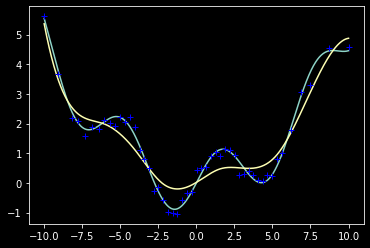

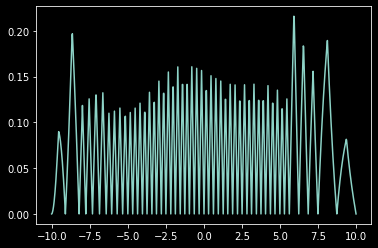

In [277]:
limits = np.array([-10, 10], dtype=float)
line = None
funIt = 50
x = np.linspace(*limits, 1000)
plt.figure(0)

plt.plot(x, f(x))

X = limits #- (limits-np.mean(limits))/4
Y = slow(X)
xs = np.zeros([funIt-2, len(x)])
ys = np.zeros([funIt-2, len(x)])

for i in range(funIt-2):
    approx = fit(X, Y)
    error = uncertainty(fit, limits, X, x)
    nxt = np.argmax(error)

    index = bisect.bisect(X, x[nxt])
    X = np.insert(X, index, x[nxt])
    Y = np.insert(Y, index, slow(x[nxt]))
    
    xs[i,:] = x
    ys[i,:] = approx(x)
    
approx = fit(X, Y)
error = uncertainty(approx, limits, X, x)
plt.figure(0)
plt.plot(x, approx(x))
plt.figure(0)
plt.plot(X, Y, "b+")
plt.figure(1)
plt.plot(x, error)
midLim = min(len(x)-2, max(np.argmin(approx(x)),1))
lims = [x[midLim - 1], x[midLim + 1]]
print(f"This Method = {opt.fminbound(approx,  *lims, maxfun=1000, disp = 0)}")
print(f"fminbound with same number of iterations = {opt.fminbound(slow, *limits, disp = 0, maxfun = funIt)}")
midLim = min(len(x)-2, max(np.argmin(f(x)),1))
lims = [x[midLim - 1], x[midLim + 1]]
print(f"fminbound with 500 iterations max = {opt.fminbound(f, *lims, disp = 0)}")


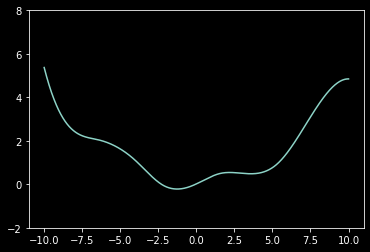

In [278]:
Figure = plt.figure()
lines_plotted = plt.plot([])
line_plotted = lines_plotted[0]
plt.xlim([-11, 11])
plt.ylim((-2, 8))
pltName = "optimiser.html"

def createGif(frame, x, y):
    line_plotted.set_data((x[frame,:], y[frame,:]))


anim_created = FuncAnimation(
    Figure, lambda i: createGif(i, xs, ys), frames=funIt-2)

writer = HTMLWriter(fps = 2)
anim_created.save(pltName, writer=writer)
HTML(pltName)


In [279]:
trueValue = -1.42755177897199
size = [15, 50]
epsilon_linspace = np.zeros(size)
epsilon_fmin = np.zeros(size)
epsilon_aLearning = np.zeros(size)
x = np.linspace(*limits, 1000)

for j in range(size[1]):
    for s in range(2,size[0]):
        _X = limits
        _Y = slow(_X)
        for i in range(2,s):
            _approx = fit(_X, _Y)
            _error = uncertainty(fit, limits, _X, x)
            _nxt = np.argmax(_error)
            _index = bisect.bisect(_X, x[_nxt])
            _X = np.insert(_X, _index, x[_nxt])
            _Y = np.insert(_Y, _index, slow(x[_nxt]))
        _approx = fit(_X, _Y)
        _index = min(max(1, np.argmin(_approx(x))), len(x)-2)
        epsilon_aLearning[s, j] = opt.fminbound(_approx, x[_index-1], x[_index+1], maxfun=1000, disp =0) - trueValue
        print(f"\r{j,s}", end="")

for j in range(size[1]):
    for i in range(2, size[0]+2):
        xbar = np.linspace(*limits, i)
        epsilon_linspace[i-2, j] = xbar[np.argmin(slow(xbar))] - trueValue
        epsilon_fmin[i-2, j] = opt.fminbound(slow, *limits, disp=0, maxfun=i) - trueValue


(49, 14)

In [280]:
np.savetxt('epsilon_fmin.csv',epsilon_fmin)
np.savetxt('epsilon_aLearning.csv',epsilon_aLearning)
np.savetxt('epsilon_linspace.csv',epsilon_linspace)


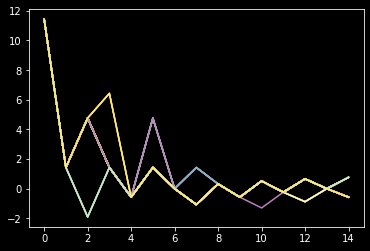

In [281]:
plt.plot(epsilon_linspace)

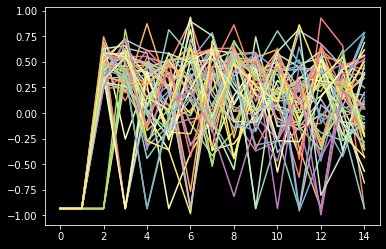

In [282]:
plt.plot(epsilon_fmin)

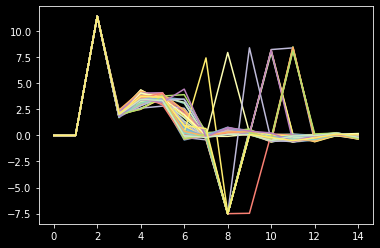

In [283]:
plt.plot(epsilon_aLearning)

In [3]:
def randFunc():
    lims = [-10, 10]
    derivatives = 1
    interval = np.linspace(*lims, 5000)
    f = np.zeros([derivatives + 1, len(interval)])
    f[-1, :] = np.random.normal(0, 0.5, np.shape(interval))
    for i in range(1, derivatives):
        f[i, 0] = np.random.uniform(-1, 1)

    for i in range(1, len(interval)):
        for j in range(derivatives):
            f[j, i] = f[j, i - 1] + f[j + 1, i - 1] * (interval[1] - interval[0])
    plt.figure()
    plt.plot(interval, f[0, :])
    return interp1d(interval, f[0, :])


size = 300
funcs = np.array([randFunc() for i in range(size)])
depth = np.array([4 + (i % 6) for i in range(size)])
correct = np.zeros_like(funcs)
elim = np.linspace(-10, 10, 5000)
correct = np.array([elim[np.argmin(f(elim))] for f in funcs])
pathway = [[0] * (i - 2) for i in depth]


def find(path, f, ans):
    s = len(path)
    _X = limits
    _Y = f(_X)
    for i in range(2, s):
        _approx = fit(_X, _Y, path[i - 2])
        _error = uncertainty(fit, limits, _X, x)
        _nxt = np.argmax(_error)
        _index = bisect.bisect(_X, x[_nxt])
        _X = np.insert(_X, _index, x[_nxt])
        _Y = np.insert(_Y, _index, slow(x[_nxt]))
    _approx = fit(_X, _Y, path[-1])
    _index = min(max(1, np.argmin(_approx(x))), len(x) - 2)
    returnmidLim = min(len(x) - 2, max(np.argmin(approx(x)), 1))
    lims = [x[midLim - 1], x[midLim + 1]]
    result = opt.fminbound(_approx, *lims)

    return abs(result - ans)


results = [0] * size
for i in range(len(funcs)):
    # boundaries = [(0, len(pathway[i])) for j in range(len(pathway[i]))]
    # pathway[i] = (opt.minimize(lambda x: find(x, funcs[i], correct[i]), list(pathway[i]), bounds=boundaries))["x"]
    results[i] = opt.fminbound(
        lambda x: find([x] * len(pathway[i]), funcs[i], correct[i]),
        0,
        len(pathway[i]) * 5,
    )
    print(f"\r{i+1} out of {size}", end="")

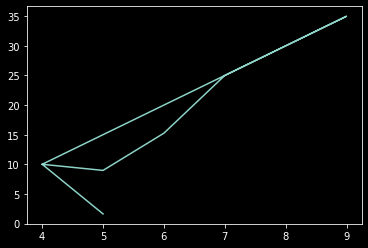

In [305]:

plt.plot(depth, np.array(results))